In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Definiamo i nomi delle colonne
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
    'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
    'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

data = pd.read_csv('wdbc.data', header=None, names=column_names)

data.drop('id', axis=1, inplace=True)
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])  # 0=B, 1=M


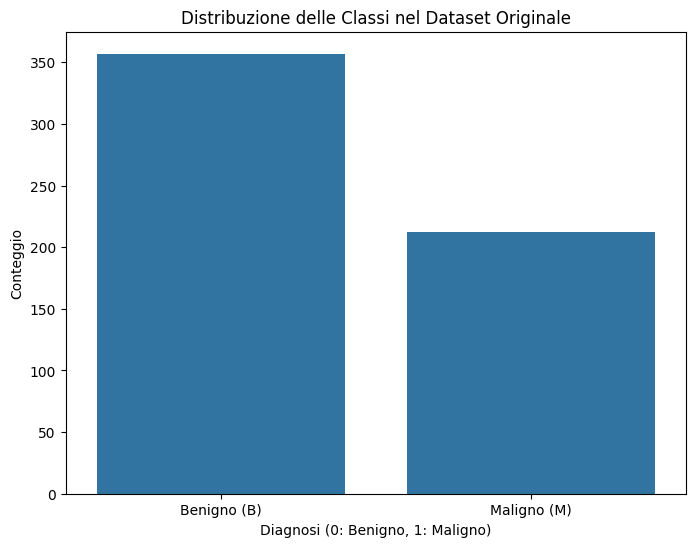

In [2]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=data)
plt.title('Distribuzione delle Classi nel Dataset Originale')
plt.xlabel('Diagnosi (0: Benigno, 1: Maligno)')
plt.ylabel('Conteggio')
plt.xticks([0, 1], ['Benigno (B)', 'Maligno (M)'])
plt.show()

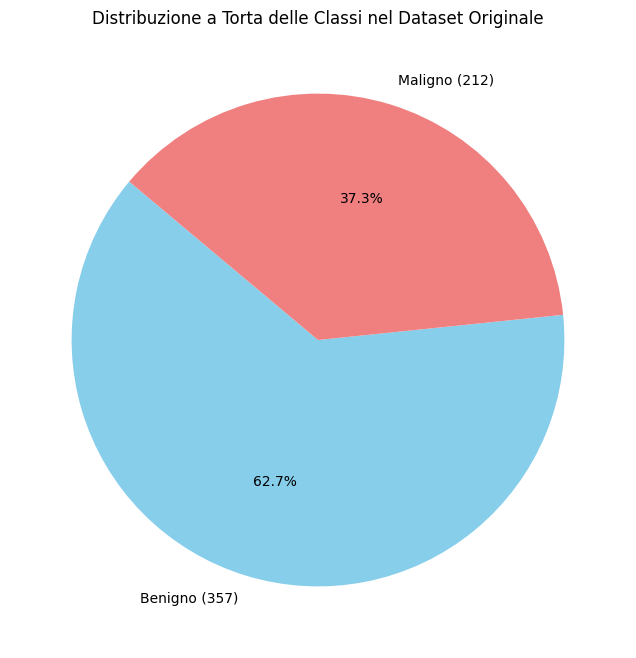

In [3]:
plt.figure(figsize=(8, 8))
counts = data['diagnosis'].value_counts()
labels = [f'Benigno ({counts[0]})', f'Maligno ({counts[1]})']
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribuzione a Torta delle Classi nel Dataset Originale')
plt.ylabel('')
plt.show()

In [4]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test = scaler.transform(X_test)

print(f"Forma train dopo SMOTE: {X_train_sm.shape}, Classi bilanciate: {np.bincount(y_train_sm)}")

Forma train dopo SMOTE: (500, 30), Classi bilanciate: [250 250]


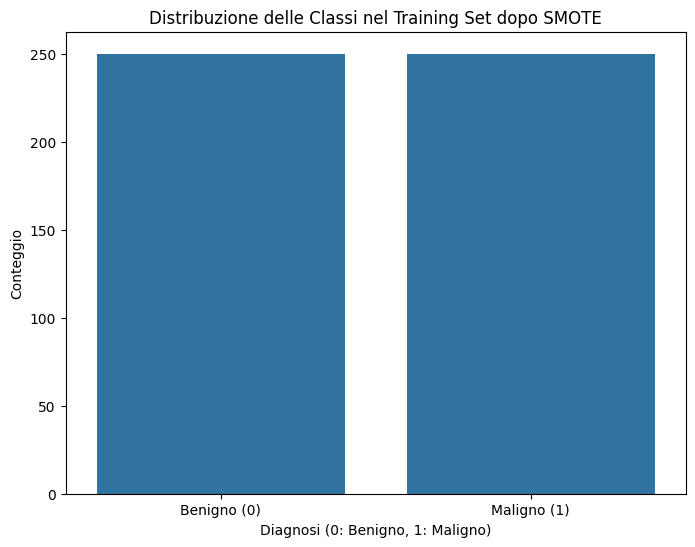

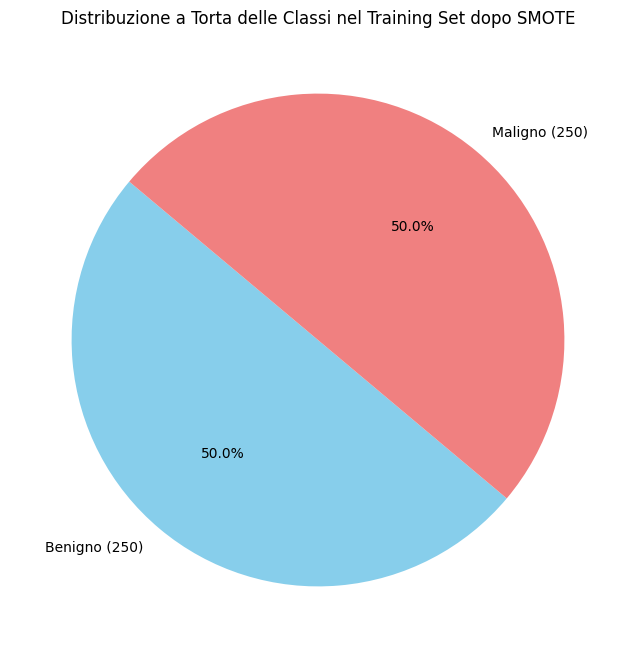

In [5]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_sm)
plt.title('Distribuzione delle Classi nel Training Set dopo SMOTE')
plt.xlabel('Diagnosi (0: Benigno, 1: Maligno)')
plt.ylabel('Conteggio')
plt.xticks([0, 1], ['Benigno (0)', 'Maligno (1)'])
plt.show()

plt.figure(figsize=(8, 8))
counts = np.bincount(y_train_sm)
labels = [f'Benigno ({counts[0]})', f'Maligno ({counts[1]})']
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribuzione a Torta delle Classi nel Training Set dopo SMOTE')
plt.ylabel('')
plt.show()

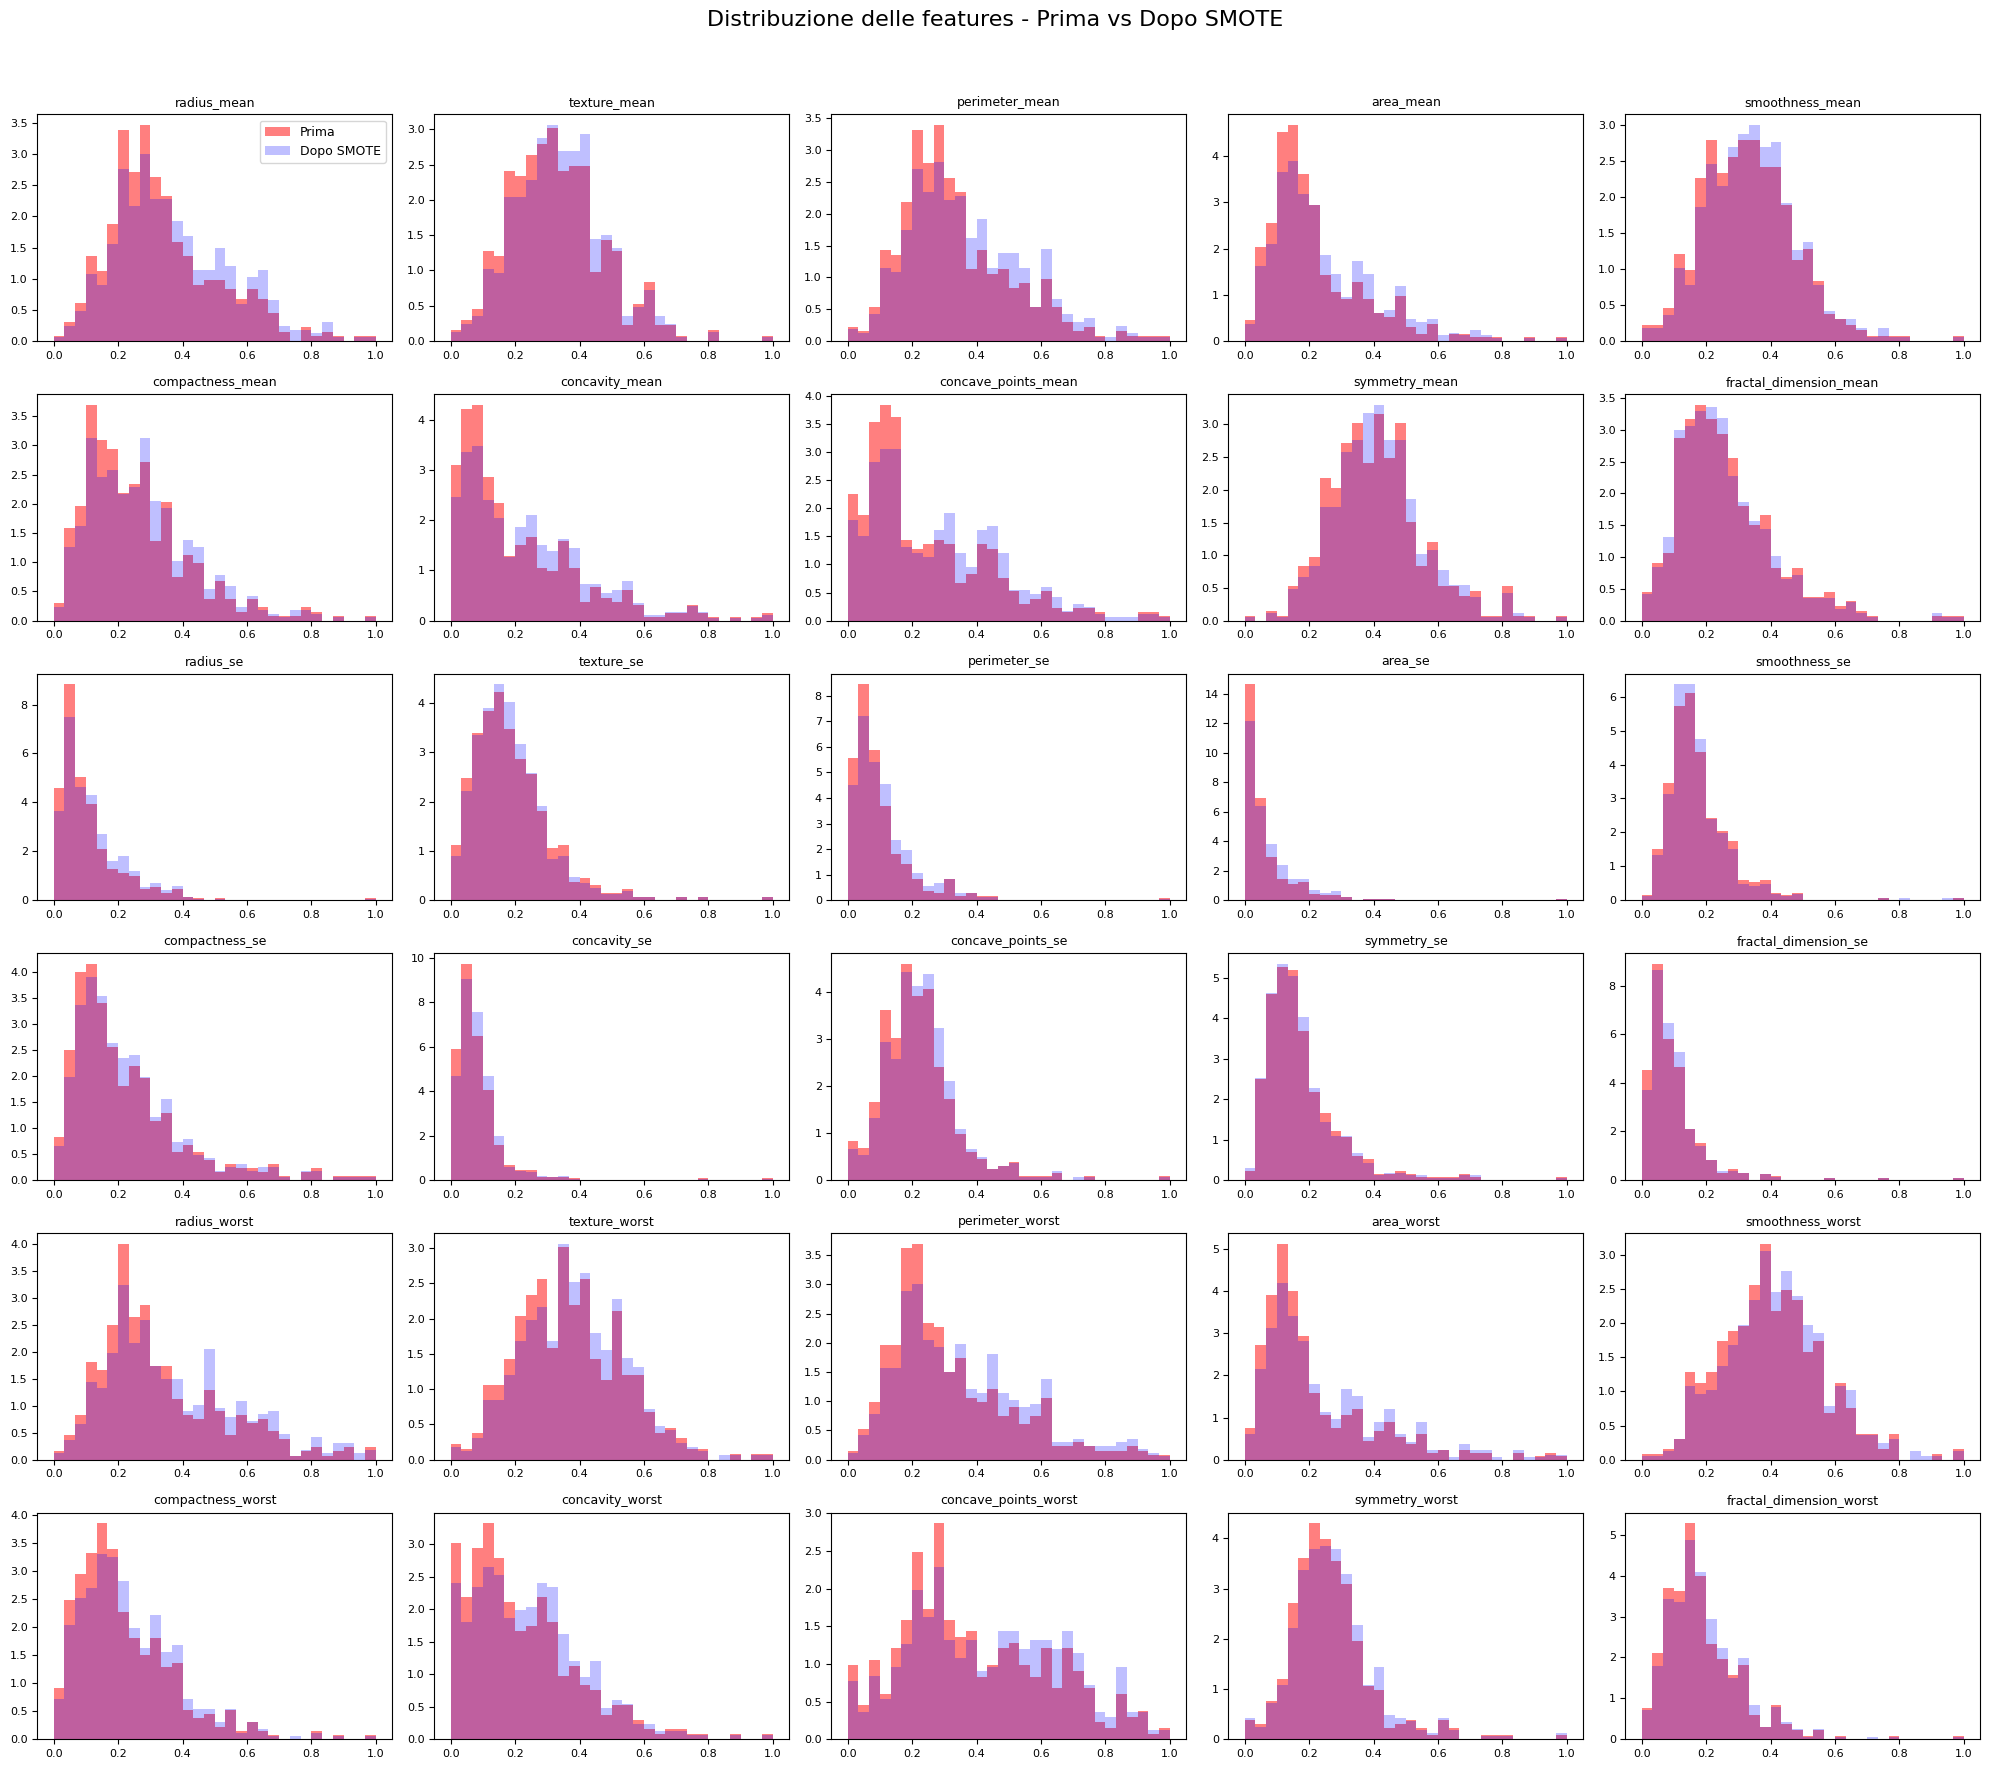

In [6]:
cols = X_train.columns
X_train_scaled = scaler.transform(X_train)

n_cols = 5
n_rows = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))
axes = axes.ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(X_train_scaled[:, i], bins=30, alpha=0.5,  color='red', density=True, label='Prima')
    ax.hist(X_train_sm[:, i], bins=30, alpha=0.25, color='blue',   density=True, label='Dopo SMOTE')
    ax.set_title(col, fontsize=9)
    ax.tick_params(axis='both', labelsize=8)


axes[0].legend(fontsize=9)

plt.suptitle('Distribuzione delle features - Prima vs Dopo SMOTE', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

models = {
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'GB': GradientBoostingClassifier(random_state=42),
    'LR': LogisticRegression(max_iter=100000, random_state=42)
}

param_dists = {
    'RF': {
        'n_estimators': [10, 50, 100,],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [10, 15, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'GB': {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10, 15],
        'subsample': [0.8, 1.0]
    },
    'LR': [
        {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear']
        },
        {
            'penalty': ['l2'],
            'C': [0.1, 1, 10, 100],
            'solver': ['lbfgs']
        }
    ]
}

best_models = {}
for name, model in models.items():
    print(f"--- {name} ---")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dists[name],
        n_iter=10,
        cv=10,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train_sm, y_train_sm)

    best_models[name] = search.best_estimator_
    print(f"Migliori parametri: {search.best_params_}")

    # Valutazione sul test set
    y_pred_test = best_models[name].predict(X_test)
    print("\nReport di classificazione sul test set:")
    print(classification_report(y_test, y_pred_test, target_names=['Benigno (0)', 'Maligno (1)']))
    print("\n" + "="*60 + "\n")

--- RF ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25135_69031d33983a4b49b55aef61adacce47_fb51426450e3406492a74ba1c6ec79cb for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25135-uxqmhzr5 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resourc

Migliori parametri: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'criterion': 'entropy'}

Report di classificazione sul test set:
              precision    recall  f1-score   support

 Benigno (0)       0.97      0.99      0.98       107
 Maligno (1)       0.98      0.95      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



--- KNN ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Migliori parametri: {'weights': 'distance', 'p': 1, 'n_neighbors': 10}

Report di classificazione sul test set:
              precision    recall  f1-score   support

 Benigno (0)       0.96      0.99      0.98       107
 Maligno (1)       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.

Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25135_69031d33983a4b49b55aef61adacce47_990a0b6dff5b4c3da41bcf63a8b4b92e for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25135_6ee241a200ff4870a86d47af62543ba2_e84aa57a051b4a429855e1addb473deb for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(

Migliori parametri: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.2}

Report di classificazione sul test set:
              precision    recall  f1-score   support

 Benigno (0)       0.96      1.00      0.98       107
 Maligno (1)       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



--- LR ---
Fitting 10 folds for each of 10 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25135_c784e04bc7b44c4c9b3c737c5448899a_7ca20230021c451a95898999f8063e97 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_25135_69031d33983a4b49b55aef61adacce47_2c68898f82804cfea914e41448927156 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(

Migliori parametri: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}

Report di classificazione sul test set:
              precision    recall  f1-score   support

 Benigno (0)       0.96      0.99      0.98       107
 Maligno (1)       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171





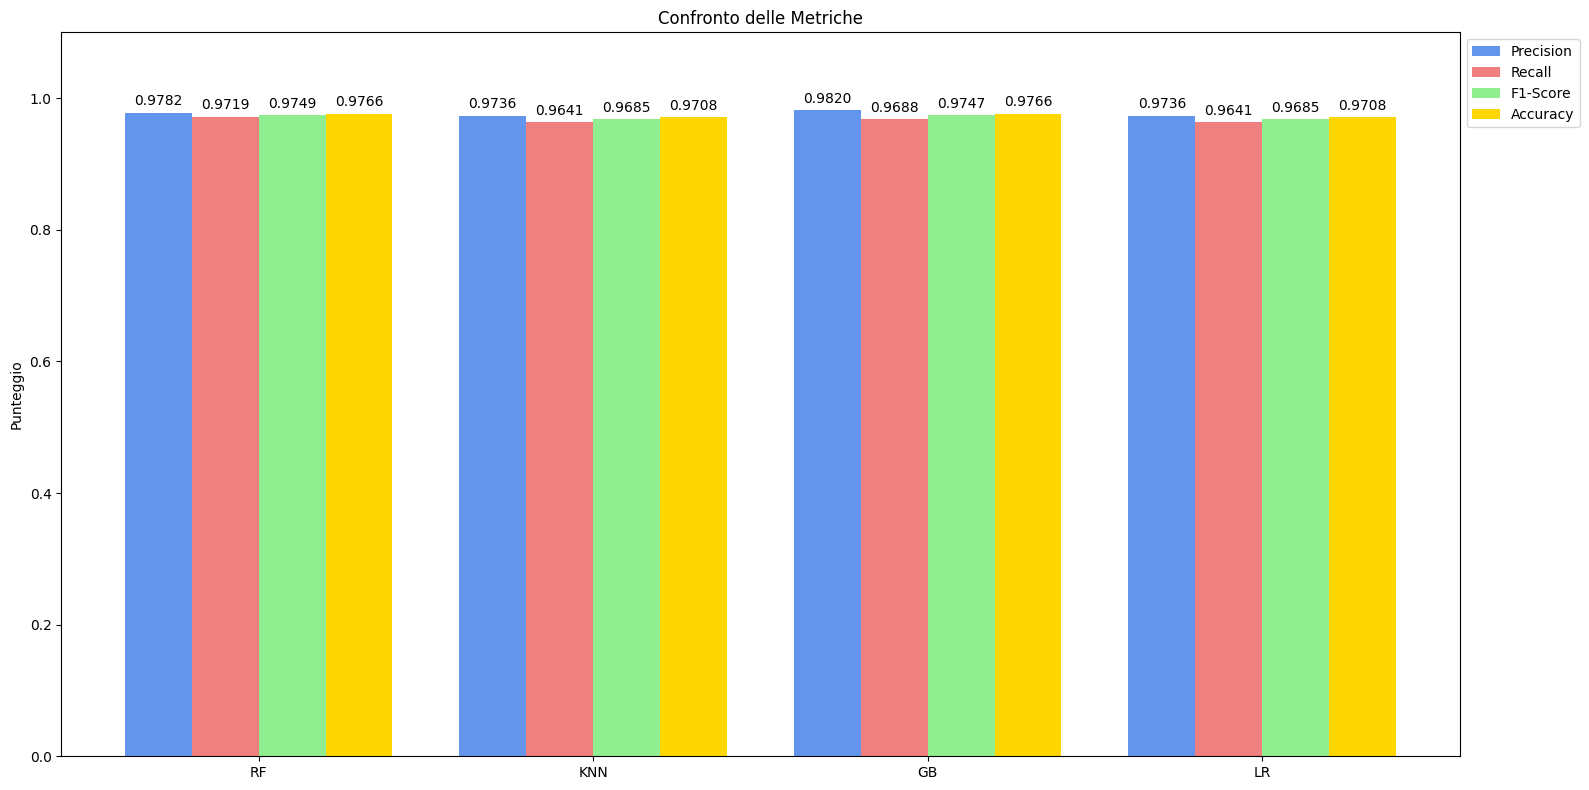

Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25135-b_u4x708 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25135-e9ha1_e8 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-25135-60wj1oc8 for automatic clea

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

metrics_per_model = {}
metrics_to_plot = ['precision', 'recall', 'f1-score']

# Calcola le metriche per ogni modello
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    # Estrai le metriche 'macro avg'
    metrics_per_model[name] = {metric: report['macro avg'][metric] for metric in metrics_to_plot}
    # Aggiungi l'accuracy
    metrics_per_model[name]['accuracy'] = accuracy_score(y_test, y_pred)

# Prepara i dati per il grafico
labels = list(metrics_per_model.keys())
precision_scores = [metrics_per_model[model]['precision'] for model in labels]
recall_scores = [metrics_per_model[model]['recall'] for model in labels]
f1_scores = [metrics_per_model[model]['f1-score'] for model in labels]
accuracy_scores = [metrics_per_model[model]['accuracy'] for model in labels]

x = np.arange(len(labels))  # Posizioni delle etichette
width = 0.2  # Larghezza delle barre

# Crea il grafico a barre
fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - 1.5*width, precision_scores, width, label='Precision', color='cornflowerblue')
rects2 = ax.bar(x - 0.5*width, recall_scores, width, label='Recall', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1-Score', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, accuracy_scores, width, label='Accuracy', color='gold')

# Aggiungi etichette, titolo e legenda
ax.set_ylabel('Punteggio')
ax.set_title('Confronto delle Metriche')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(0, 1.1)

# Aggiungi le etichette con i valori sopra le barre
ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')
ax.bar_label(rects3, padding=3, fmt='%.4f')
ax.bar_label(rects4, padding=3, fmt='%.4f')

fig.tight_layout()
plt.show()